<a href="https://colab.research.google.com/github/mdh266/TextClassificationApp/blob/feature%2Fkeras/NLP_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification 4: Deep Learning With Tensorflow & Optuna
--------------

__[1. Introduction](#first-bullet)__

__[2. Vectorizing Text](#second-bullet)__

__[3. Handling Imbalance In The Data](#third-bullet)__

__[4. Building A Convolutional Neural Network With Keras](#fourth-bullet)__

__[5. Hyperparameter Tuning with Optuna](#fifth-bullet)__

__[6. Next Steps](#sixth-bullet)__


## Introduction <a class="anchor" id="first-bullet"></a>
------------------

In this post I want to extend on the last [model](http://michael-harmon.com/blog/NLP2.html) in my blog series on text classification where I used a SVM to predict the topic of papers in arxiv based on their abstract. For reference the topics were "Machine Learning", "Computer Vision", "Artifical Intelligence" and "Robotics" and there was imbalance in the classes.

This time I will use a [Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) model with [Tensorflow](https://www.tensorflow.org/) and [Keras](https://keras.io/) to predict the topic of each paper's abstract and use [Optuna](https://optuna.org/) to optimize the hyperparamters of the model. Keras is a high level library that makes building complex deep learning models relatively easy and since it can use [Tensorflow](https://www.tensorflow.org/) as a backend, it is a production ready framework. Optuna is powerful automatic hyperparameter tuning library that uses a *define-by-run* design that makes it elegant and easy to use. I have just started using this library and have been particularly impressed with the design which is extremely intuitve. While CNN's are no longer the state-of-the-art algorithms for text classification, they still perform quite well and I wanted to explore how they would work on this problem. I should note that, the point of this isn't to build the most high performing model, but rather to show how these tools fit together to build an end-to-end deep learning model.


Before we get started building the model let's quickly go over text vectorization as the process I use in this post is different from prior posts which used the [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model).

## Vectorizing Text <a class="anchor" id="second-bullet"></a>

Machine learning models make use of numerical data in the form of vectors that represent the values of their features. The model is really just an approximation to a function that maps the input vectors to the output (which can be a scalar or vector). In order to build machine learning models that use text data we need to convert the text to numerical vectors. To do this we use a [Vector Space Model](https://en.wikipedia.org/wiki/Vector_space_model) which repesents words as vectors in the space.

In my [first post](http://michael-harmon.com/blog/NLP1.html) in this series I went over a vector space model called  [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) along with [Term Frequency-Inverse Document Frequency (TF-IDF)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). While these are a classic representations for text, one of their pifulls is that is often produces sparse high dimensional representations. This combination can be particularly challenging for machine learning models to work with. Another shortcoming of the bag-of-words model is that it does not take into account the order of the words or the semantic relationships between words. We'll address these issues later using [Word Embeddings](https://en.wikipedia.org/wiki/Word_embedding), but first we need to discuss how to vectorize text using the TensorFlow [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) class.  

First let's grab our data from [Google Cloud Storage](https://cloud.google.com/storage) where is stored as json objects using [Pandas](https://pandas.pydata.org/).

In [130]:
from google.oauth2 import service_account
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


train_df = pd.read_json("gs://harmon-arxiv/train_abstracts.json",
                        storage_options={"token": "credentials.json"})
    
test_df = pd.read_json("gs://harmon-arxiv/test_abstracts.json",
                        storage_options={"token": "credentials.json"})

Let's convert the category to numerical values 1, 2, 3, 4 which represent the different abstract topics using the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) function:

In [131]:
from sklearn.preprocessing import LabelEncoder

labeler  = LabelEncoder()
train_df = train_df.assign(target=labeler.fit_transform(train_df["category"]))
test_df  = test_df.assign(target=labeler.fit_transform(test_df["category"]))

train_df.head()

,category,text,target
0,ai,Because of their occasional need to return to ...,0
1,ai,Market price systems constitute a well-underst...,0
2,ai,We describe an extensive study of search in GS...,0
3,ai,As real logic programmers normally use cut (!)...,0
4,ai,To support the goal of allowing users to recor...,0


Now we need to convert these documents to vectors in a vector space. We use the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) class to automatically convert documents to vectors. This class creates a dictionary of words where each word is associated with  an integer index in the dictionary. Words in the sentences are represented by their index value in the vector. The order of the words in the sentence dictate which entry of the vector they are in. For example the first word in the sentence has it index value in entry 0 in the vector, the second word has its index value in entry 1 in the vector and so on.

We cap the number of words in our dictionary (or vocabulary) at an integer called `max_tokens`. We also set the length of sentences to be capped at `sequence_length` tokens long. That means if our abstract contains less than `sequence_length` words then we pad the rest of the vectors entries with 0's to give it a length of `sequence_length`. If the abstract contains more than `sequence_length` words it will be cut short.

Let's first set `sequence_length` by looking at the number of tokens in each document by their category in a histogram:

<AxesSubplot:xlabel='num_tokens', ylabel='Count'>

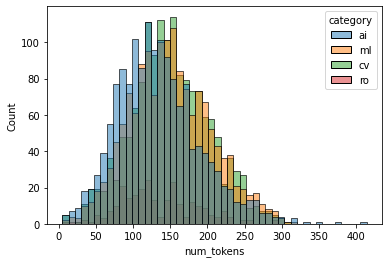

In [132]:
import seaborn as sns

train_df = train_df.assign(num_tokens=train_df.text.str.split().apply(len))

sns.histplot(data=train_df, x="num_tokens", hue="category")

We can see that most documents are between 50 and 300 words long and the max being close to 400. So let's set our max sequence length to be 300. 

Now, we'll import Tensorflow as well as the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) class. Note the version of TensorFlow I am using is 

In [133]:
import tensorflow as tf
tf.__version__

'2.8.0'

Depending on your verion of Tensorflow, [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) (along with other functions I use) may no longer be experimental and the path may be different.

We create a `TextVectorization` layer that has a max sequence length of 300 and cap the vocabulary to be 20,000. Words that are not in this vocabulary will be set to a default "unknown" token. 

In [134]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_features = 20000
sequence_length = 300

vectorize_layer = TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_mode="int",
    pad_to_max_tokens=True,
    output_sequence_length=sequence_length,
)

Now we train the layer on the entire training dataset,

In [135]:
vectorize_layer.adapt(train_df["text"].to_numpy())

2022-11-18 07:16:37.494074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Let's look at an example of a text,

In [136]:
test = train_df["text"][0]
test

'Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.'

Now let's look at the vector representation,

In [137]:
vectorize_layer.call(test)

<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([ 348,    3,   80, 9056,  408,    6, 2380,    6, 2802,  244,    7,
          4,  106,  345,  124, 2220,   39,   22, 2119, 9690, 1526, 1510,
       2481,  316,    4,  106,   33,    7,   12,   24,    9,   65,    4,
         29,   18,   20, 5380,  244,   22,   19, 6762, 2778,    7,    2,
        106,   98, 1666, 2529,   12, 1307,    2,  147,  241,    8,    4,
       1115,    3, 9833, 2220,   11,  303,   95,  568,   98,  123,  619,
        993,  396,  205,   53,    5, 3918,    2, 2471,  809,  538,   18,
       1609,  127,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

Note that our vectors are of max sequence length (300), not the vocabulary length (20,000). Since the above sentence did not have 300 words in it, we pad the vector with 0's to make sure the vectors are all of the same length.

The i-th entry in the above vector corresponds to the i-th word in sequence of words in the text. The value of the entry in the vector is the index for that word in our vocabulary.

The first entry is 348 which means that the word "Because" is the 348th entry in our 20,000 vocabulary list. The second entry is 3, which means the word "of" is the 3rd entry in our vocabulary list.

Let's try a word that most likely isnt on our vocabulary to see what the default token's entry is in our vocabulary list

In [138]:
vectorize_layer.call("onomatopoeia triglycerides")

<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

We can see that the word "onomatopeoia" and "triglycerides" are both represented by a 1 which means the unknown token in our vocabulary is 1. Let's get the dictionary of words which we'll need later by using the `.get_vocabulary` method.

In [139]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

## Handling Imbalance In The Data <a class="anchor" id="third-bullet"></a>

I found the most natural way to deal with imbalanced data in Keras was using weights, similar to the way I did in the [first blog post](http://michael-harmon.com/blog/NLP1.html) in this series. In other frameworks like [Scikit-Learn](https://scikit-learn.org/stable/) the weights for each class are determined automatically, however, with Kera's I found I neeeded to set them explicitly.

Luckily we can use Scikit-Learn's [compute_class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) function to get estimates for the weights,

In [140]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
                                   'balanced',
                                    classes= np.unique(train_df["target"]), 
                                    y=train_df["target"])

print(f"class_weights: {class_weights}")

class_weights: [0.79084967 0.79084967 0.79084967 4.84      ]


Then we can convert that into a dictionary for each class and its corresponding weight:

In [141]:
weights_dict = dict(zip(range(4), class_weights))
print(f"weights_dict: {weights_dict}")

weights_dict: {0: 0.7908496732026143, 1: 0.7908496732026143, 2: 0.7908496732026143, 3: 4.84}


We're cheating a little here because were using the entire dataset for calculating the dataset, but we wont be using cross validation so it's not so bad.

Let's take a look at the data again, but this time look at distribution of the target variable with respect to the index in the dataframe:

<AxesSubplot:xlabel='index', ylabel='target'>

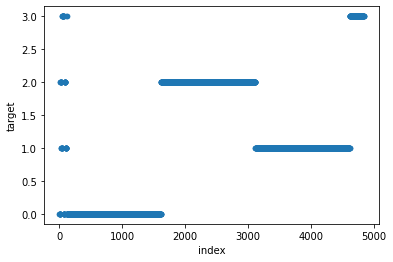

In [142]:
train_df.reset_index().plot('index', 'target', kind='scatter')

The dataset is ordered by the target variable which can be a problem for deep learning models. Deep learning models use [mini-batch gradient descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) which use small batches of the original dataset to train on instead of the entire dataset. If the data is ordered according to the target variable, depending on the size of the bathces, each batch most likely will only have data from one class making the model unable to discern differences between classes.

To avoid this situation we want to shuffle the dataset first so that the model will get a sufficient representation of  each class in each batch during training.

In [147]:
from sklearn.utils import shuffle

train_df = shuffle(train_df, random_state=33)
test_df = shuffle(test_df, random_state=33)

Now the data looks much more evenly distributed across the index of the dataframe!

<AxesSubplot:xlabel='index', ylabel='target'>

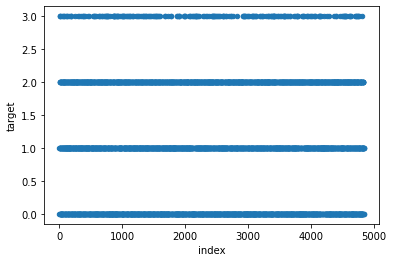

In [148]:
(train_df.reset_index(drop=True)
               .reset_index()
               .plot('index', 'target', kind='scatter'))

Notice that I didnt have to worry about this in prior blog post's models since Scikit-Learn by default uses statified sampling to create folds in [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Those prior models also train on all the date in each fold in cross-validation.

Lastly before we get started with building a model we one-hot encode the target classes using the [label_binarize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html) function:

In [149]:
from sklearn.preprocessing import label_binarize

# classes = [0,1,2,3]
classes   = np.sort(train_df["target"].unique())

# relabel the test set
y_train = label_binarize(train_df["target"],
                         classes=classes)

y_test = label_binarize(test_df["target"], 
                       classes=classes)

We can see that the results are a 4-dimensional vector,

In [150]:
y_train[0]

array([1, 0, 0, 0])

Now we can move onto building a convolutional neural network using Keras!

## Building A Convolutional Neural Network With Keras <a class="anchor" id="fourth-bullet"></a>

We will use a [Convolution Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) with the architecture shown below,

<figure>
<img src="images/Basic-architecture-of-CNN.png" alt="Trulli" style="width:75%">
<figcaption align = "center">
    From https://www.researchgate.net/figure/Basic-architecture-of-CNN_fig3_335086346
</figcaption>
</figure>

This is a pretty classic architecture for text classification that uses two [1D Convolutional Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) with an [ReLU activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and [1D MaxPooling Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool1D). This is followed by a [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), [Dropout layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) and a [softmax layer](https://en.wikipedia.org/wiki/Softmax_function) for predicting one of the four classes. The one thing that the above diagram does show is that input layer is using an [Embedding layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

[Word Emeddings](https://en.wikipedia.org/wiki/Word_embedding) (or embeddings) allows us to represent words in a dense low-dimensional vector space instead of a high-dimensional sparse vector space as with the bag-of-words model. In addition to reducing dimensionality they also allow us to learn semantic relationship between words such as man is to woman as king is to queen.

A more detailed look at the convolutional/max pooling block is shown below, 

<figure>
<img src="images/1d-convolutional.jpg" alt="Trulli" style="width:75%">
<figcaption align = "center">
    From https://www.researchgate.net/figure/a-Simple-scheme-of-a-one-dimension-1D-convolutional-operation-b-Full_fig2_334609713
</figcaption>
</figure>

A convolutional layer is made up filters (or kernels) that have weights which must be learned. The kernel size is the number of weights in each filter and are shown in pink. We take the sum-product of the weights and entries in the input vector and apply an [ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) to form new entries in a the output layer. We slide this filter over all windows of size [kernel_size](https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean) in the input layer to fill out entries in the output layer (yellow square).

In this sliding mechanism we skip entries in the input space bewteen the ending of the application of the filter and start of the next application of the filter. The number of entries that we skip is called the [stride size](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/). This process is called a convolution and results in an output dimensions that is smaller than the input dimensions. We can supress this reduction in dimension by [padding](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/) the input vector with 0's so that the output is the same size as the input size. Allowing the output space to be reduced in dimension is called "valid" padding and supressing this is called "same" padding.

The [max pooling layer](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) looks at the values in a window of the convolutions output layer and finds the maximum value and makes that the value in the output cell. Another depiction of the process is shown below,

<figure>
<img src="images/1D-max-pooling-operation.png" alt="Trulli" style="width:75%">
<figcaption align = "center">
    From https://www.researchgate.net/figure/1D-max-pooling-operation_fig4_324177888
</figcaption>
</figure>


The window size is again called the `pool_size` (in the above its labeled as `pooling_size`). MaxPooling also has the concept of `stride` and `padding` that a convolutional layer has. The point of MaxPooling is to make the repesentation more invariant to transformations, a concept that is more intuitive for me when applying CNNs to computer vision.

The last technique for CNNs we will discuss is [drop out](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/). Drop out is a form of regularization that randomly sets the weights of specific neurons in a layer to zero during training time. This is shown below,

<figure>
<img src="images/dropout.jpg" alt="Trulli" style="width:75%">
<figcaption align = "center">
    From https://wenkangwei.github.io/2020/11/13/DL-DropOut/
</figcaption>
</figure>


Drop out prevents overfittings by making the network not overly dependent on any one neuron in the hidden layers. Usually drop out is not performed on in the input layer, and is reserved for the deepest layers as those are the most likely to have overfitting.

Now that we have gone over the basics of the CNN architecture let's get building a model! 

We can import the necessary modules and see if we are using a GPU for training: 

In [151]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses

Let's set the logging to only log errors and also test to make sure we have a working GPU.

In [152]:
tf.compat.v1.logging.set_verbosity('ERROR')
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Since we dont have too much data relative to amount usually needed for deep learning usually we would use [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) by using a pre-trained embedding, however, I found this actually performed worse which could be due to the technical nature of the words we are using.

One option to fix this would be to adapt a pre-trained embedding layer to the specifics of our data. In order to do that people generally let the model train with a fixed embedding matrix for a few iterations before setting the embedding layer to be traininable. The reason for this is because the first few iterations of gradient descent have large gradients that would completely change the values of the embedding layer and inject a ton of noise into the model. However, after a few iterations of gradient descent the gradients won't be so dramatic and we can unfreeze the embedding layer to allow the coefficents to be fine tuned to the specifics of the model. 

For this problem, I found this didnt work well either and instead we'll simplicity just train the embedding as part of the model building process.

Next we define a function that returns a compiled Keras model. The function takes as inputs all the hyperparameters that we want to optimize our model for. Setting up a function to do this will simplify the procedure to optimize the hyperparameters of the model. Note that the function below has default values so that we can call the function without any parameters being passed.

In [153]:
def build_model(
    embedding_dim: int=128,
    filters: int=8,
    kernel_size: int=5,
    stride_size: int=3,
    conv_padding: str="valid",
    pool_padding: str="same",
    dropout: float=0.2
) -> Sequential:
    
    model = Sequential([
                # Embedding Layer
                tf.keras.Input(shape=(1,), 
                               dtype=tf.string, 
                               name='text'),
                vectorize_layer,
                # embedding_layer,
                layers.Embedding(max_features, embedding_dim),
            
                # Convolutional Layers
                layers.Conv1D(filters, 
                              kernel_size, 
                              padding=conv_padding, 
                              activation="relu", 
                              strides=stride_size),
        
                layers.MaxPooling1D(padding=pool_padding),
        
                layers.Conv1D(filters, 
                              kernel_size, 
                              padding=conv_padding, 
                              activation="relu", 
                              strides=stride_size),
        
                layers.GlobalMaxPool1D(),

                # Add a vanilla hidden layer:
                layers.Dense(filters, activation="relu"),
                layers.Dropout(dropout),

                # softmax layer
                layers.Dense(4, activation="softmax")
    ])

    # sceduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate=1e-2,
                            decay_steps=1000,
                            decay_rate=0.2)
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), 
                  metrics=["accuracy", tf.keras.metrics.AUC(name='prc', curve='PR')])

    return model

We can now create a default model and see the number of unknowns in each layer as well as the total number of unknowns using the summary method,

In [154]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 300, 128)          2560000   
                                                                 
 conv1d_6 (Conv1D)           (None, 99, 8)             5128      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 50, 8)            0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 16, 8)             328       
                                                                 
 global_max_pooling1d_3 (Glo  (None, 8)               

The number of coefficents in this model is dominated by the word embedding. For this configuration the model has over 2 million coefficents which makes it quite complex!

Next let's turn to how we optimize the hyperparameters of our model using Optuna.

## Hyperparameter Tuning with Optuna <a class="anchor" id="fourth-bullet"></a>

Optuna is powerful hyperparameter tuning library that uses a define-by-run design that makes it elegant and easy to use. I have just started using this powerful library and have been particularly impressed with the design and felt it was extremely intuitve. The three things to take into account for a optimization run in Optuna are *Trial*, *Study*, *Parameter*. These are defined as,

- **Trial**: A single call of the objective function

- **Study**: An optimization session, which is a set of trials

- **Parameter**: A variable whose value is to be optimized, such as `dropout` rate in the `build_model` function.

The first thing we do is to define an **objective function**; this is the function we want to maximize (or minimize). This is a function of a trial which is a process of evaluating an objective function and provides interfaces to get the **parameter** suggestions.

Notice that each hyperparameter of the model is defined as a parameter in the `build_model` function and is given a suggested value for each trial. The model is then fit to the dataset and returns the area under the curve (AUC) of the precision-recall curve (PR curve) on the validation data set. After running a predfined number of trials in the study, the model with the best AUC-PR on the validation data set is chosen as the final model. 

In [162]:
import optuna

def objective(trial):
    tf.keras.backend.clear_session()
    
    model = build_model(embedding_dim=trial.suggest_categorical("embedding_dim", [16, 32, 64, 128]),
                        conv_padding=trial.suggest_categorical("conv_padding", ["valid", "same"]),
                        pool_padding=trial.suggest_categorical("pool_padding", ["valid", "same"]),
                        kernel_size=trial.suggest_categorical("kernel_size", [8, 16, 24]),
                        stride_size=trial.suggest_categorical("stride_size", [1, 2, 3, 5]),
                        dropout=trial.suggest_float("dropout", 0.2, 0.5))
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                         restore_best_weights=True)
    
    history = model.fit(train_df["text"], 
                        y_train, 
                        epochs=20, 
                        batch_size=trial.suggest_categorical("batch_size", [32, 64, 128]),
                        class_weight=weights_dict, 
                        validation_split=0.2,
                        callbacks=[early_stopping_cb],
                        verbose=False)
    
    scores = history.history["val_prc"]
    
    # get the last epochs scores
    return max(scores)

Before we start our Optuna study we create a backend storage to keep the results of every trial. We can use it to reload the the results of each study if necessary, which i FO In this set up I will use a local [sqlite](https://www.sqlite.org/index.html) database.

In [163]:
optuna_storage = optuna.storages.RDBStorage(
    url="sqlite:///tunning.db",
    engine_kwargs={"connect_args": {"timeout": 10}},
)

Now we can create a the study with its name and to `maximize` the objective function. We also set the storage to be the sqlite database created above.

In [164]:
study = optuna.create_study(study_name="study_one", 
                            direction="maximize", 
                            storage=optuna_storage)

Well just create a small study of 30 trials to show the effectiveness of Optuna and fead the study the objective function through the `optimize` method.

In [185]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, 
               n_trials=30,
               timeout=600)

We can see the results of each trial in the study as a Pandas dataframe,

In [166]:
study.trials_dataframe().sort_values("value", ascending=False).head(3)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_conv_padding,params_dropout,params_embedding_dim,params_kernel_size,params_pool_padding,params_stride_size,state
2,2,0.922710,2022-11-18 07:21:35.263205,2022-11-18 07:22:36.247542,0 days 00:01:00.984337,64,same,0.232188,128,24,same,2,COMPLETE
4,4,0.888039,2022-11-18 07:24:29.862892,2022-11-18 07:25:35.354486,0 days 00:01:05.491594,64,valid,0.332368,64,8,same,5,COMPLETE
3,3,0.880042,2022-11-18 07:22:36.253876,2022-11-18 07:24:29.853067,0 days 00:01:53.599191,32,same,0.252965,128,16,valid,5,COMPLETE


The best trial got AUC-PR OF 0.922 which is pretty good.

We can reload the results of the study by passing the name of the study and the backend storage.

study = optuna.load_study(study_name="study_one", storage=optuna_storage)

Then we can get the accuracy of the best model on the validation set 

In [169]:
study.best_value

0.9227098226547241

We can get the parameters of the model,

In [170]:
best_params = study.best_params.copy()

In [171]:
best_params

{'batch_size': 64,
 'conv_padding': 'same',
 'dropout': 0.232187759007721,
 'embedding_dim': 128,
 'kernel_size': 24,
 'pool_padding': 'same',
 'stride_size': 2}

In [172]:
batch_size = best_params.pop("batch_size")

And then use these values to fit the best model on the training set again,

In [180]:
model = build_model(**best_params)

In [181]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                     restore_best_weights=True)

history = model.fit(train_df["text"], 
                    y_train, 
                    epochs=20, 
                    batch_size=batch_size,
                    class_weight=weights_dict, 
                    validation_split=0.2,
                    callbacks=[early_stopping_cb],
                    verbose=False)

2022-11-18 07:42:06.175271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-18 07:42:14.882599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


We can now plot the learning curves to see how our model is performing,

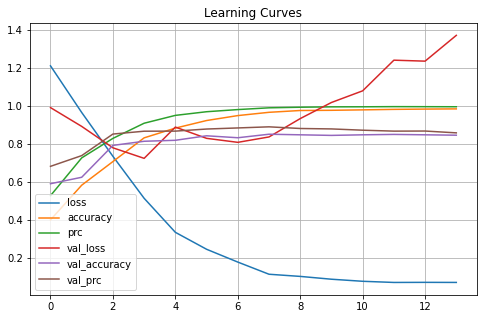

In [184]:
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(8,5))
plt.grid(True)
plt.title("Learning Curves")
plt.show()

The validation loss shows that the model quickly starts overtraining after 3 or 4 epochs. This is probably due to the fact we have a complex model with comparatively little data.

Let's see how well the model performs on test set.

In [175]:
sores = model.evaluate(test_df["text"], y_test)

2022-11-18 07:38:10.019040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 3s 48ms/step - loss: 1.4780 - accuracy: 0.8413 - prc: 0.8382


We can see the test set accuracy is around 84% and the AUC for the recision recall is about 83%, not too bad.

The ROC curves look pretty decent, but the PR curves dont look quite so good as the prior model, especially for the minority class. Most likely because this model is too complex for the size of the data, as well the overlap and imbalance of the classes. 

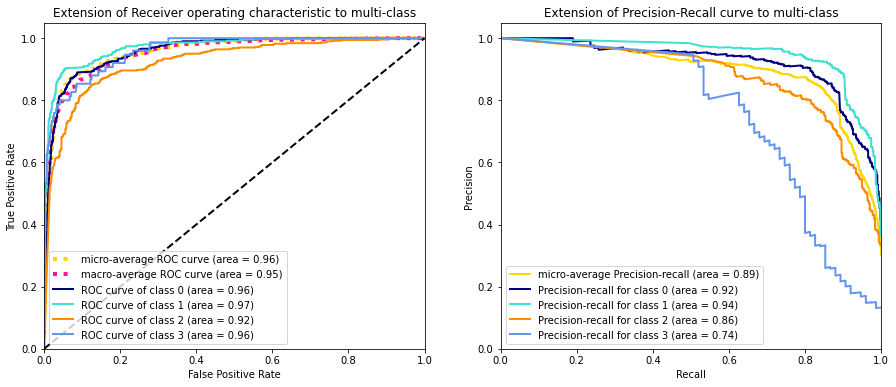

In [177]:
y_pred = model.predict(test_df["text"])

from utils.Plot_ROC_PR_Curve import plot_roc_pr
plot_roc_pr(y_pred, y_test)

Finally, we can save the model for deploying the model at a later time.

In [178]:
model.save("cnn_model")

2022-11-18 07:38:23.931305: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Next Steps <a class="anchor" id="sixth-bullet"></a>

In this post we covered how to build a Convolutional Neural Network in Keras. We optimized the model hyperparameters using the Optuna library and persisted saved model. In a follow up post we will deploy this model to production Google Cloud.

Hope you enjoyed reading this!